In [4]:
import json
with open('./data/musae_git_features.json') as f:
    features_dict = json.load(f)


# 查看总共有多少节点的特征
print("Number of nodes with features:", len(features_dict))

# 随便打印一个节点的特征内容
for k in list(features_dict.keys())[:5]:
    print(f"Node {k}: Features -> {features_dict[k]}")

    

Number of nodes with features: 37700
Node 0: Features -> [1574, 3773, 3571, 2672, 2478, 2534, 3129, 3077, 1171, 2045, 1539, 902, 1532, 2472, 1122, 2480, 3098, 2115, 1578]
Node 1: Features -> [1193, 376, 73, 290, 3129, 1852, 3077, 1171, 1022, 2045, 536, 2040, 1533, 1532, 2472, 673, 798]
Node 2: Features -> [1574, 3773, 925, 1728, 2815, 2963, 3077, 364, 1171, 536, 1867, 2472, 1122, 2532, 664, 28, 3311, 1768, 869]
Node 3: Features -> [3964, 3773, 4003, 928, 1852, 3077, 364, 1022, 3763, 2045, 3859, 3771, 234, 664, 703]
Node 4: Features -> [1929, 3773, 1793, 3511, 1290, 3129, 3077, 364, 1171, 1022, 2045, 536, 1119, 91, 1532, 3771, 1122, 703, 1001]


tensor([[0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7],
        [2, 4, 3, 4, 5, 0, 5, 6, 1, 7, 0, 1, 1, 2, 2, 7, 3, 6]])
Data(x=[8, 5], edge_index=[2, 18])


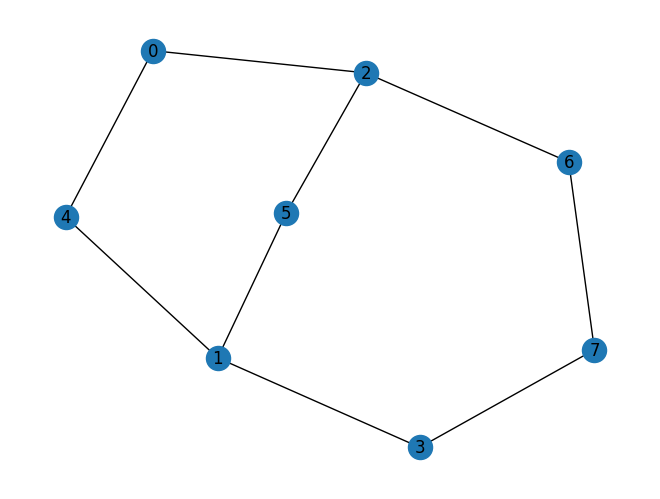

In [8]:
from torch_geometric.utils import k_hop_subgraph, to_networkx, to_undirected, to_scipy_sparse_matrix
import torch
import networkx as nx
from torch_geometric.data import Data
from scipy.sparse.csgraph import shortest_path
# dataset = KarateClub()
# data = dataset[0]
# print(data)
torch.manual_seed(0)
edge_index = torch.tensor([[1,2,3,0,4,5,6,7,1],[5,0,7,4,1,2,2,6,3]])
edge_index = to_undirected(edge_index)
print(edge_index)
x = torch.randint(low=0, high=4, size=(edge_index.unique().size(0), 5))
data = Data(edge_index=edge_index, x=x)
print(data)
G = to_networkx(data, to_undirected= True)
nx.draw(G, with_labels = True)
# edge_label_index = torch.tensor([[0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7,0,5,3,5],
#         [2, 4, 3, 4, 5, 0, 5, 6, 1, 7, 0, 1, 1, 2, 2, 7, 3, 6,5,0,5,3]])
edge_label_index = torch.tensor([[1,2,0,3],[3,0,2,1]])

In [2]:
import numpy as np

In [3]:
print(edge_label_index)


tensor([[1, 2, 0, 3],
        [3, 0, 2, 1]])


In [2]:
def scorer(x):
    score = torch.sum(x,dim = 1)
    return score

In [3]:
num_nodes = data.num_nodes
print(num_nodes)
num_features = 256
data.x = torch.randn((num_nodes, num_features))
print(data.x)

8
tensor([[-0.2159, -0.7425,  0.5627,  ...,  0.1437,  0.5836,  1.3482],
        [-1.5771,  0.3609, -1.3533,  ..., -0.0806,  0.1581,  0.1000],
        [ 3.1257,  0.1784, -0.6452,  ..., -0.1802, -0.0184,  0.9981],
        ...,
        [-0.7749,  0.1897, -0.6275,  ...,  0.6976,  1.0022,  0.3168],
        [-0.6111, -0.5673,  1.0816,  ..., -1.2524,  0.2051,  0.1210],
        [-0.0952, -0.3437, -1.3129,  ...,  0.0650,  1.3668, -0.6437]])


tensor([[0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7],
        [2, 4, 3, 4, 5, 0, 5, 6, 1, 7, 0, 1, 1, 2, 2, 7, 3, 6]])
tensor([[0, 0, 1, 2, 3, 3],
        [2, 3, 3, 0, 0, 1]])
tensor([0, 1, 2, 4])
0 3
tensor([0, 4, 2])
tensor([[0, 0, 1, 2, 3, 3],
        [2, 3, 3, 0, 0, 1]])
tensor([[0, 2],
        [2, 0]])


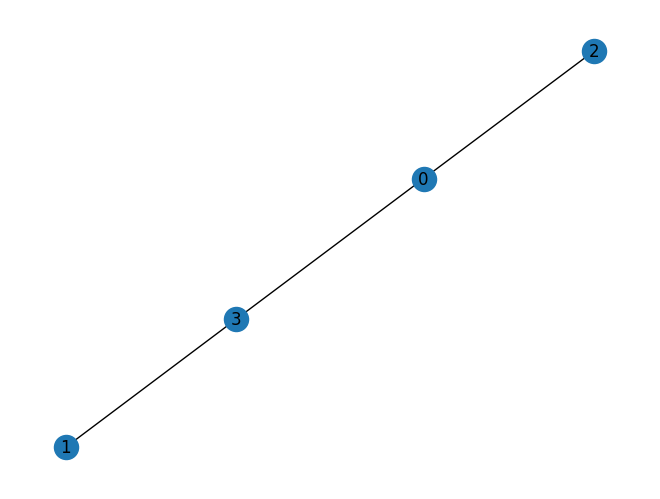

In [7]:
# for src, dst in edge_label_index.t().tolist():
src, dst = (0, 4)
print(data.edge_index)
node_idx, edge_index, mapping, _ = k_hop_subgraph(
    [src, dst], 1, data.edge_index, relabel_nodes=True)
src, dst = mapping.tolist()
print(edge_index)
print(node_idx)
print(src,dst)

G = nx.Graph()
G.add_edges_from(edge_index.t().tolist())
nx.draw(G, with_labels = True)
x_sub = data.x[node_idx]
all_indices = torch.arange(len(node_idx))
mask_src_dst = torch.ones(len(node_idx), dtype=torch.bool)
mask_src_dst[src] = False
mask_src_dst[dst] = False

x_sub_wo_srcdst = x_sub[mask_src_dst]
with torch.no_grad():
    score = scorer(x_sub_wo_srcdst)
n = 1
idx_top = score.topk(n).indices
neighbors_idx = all_indices[mask_src_dst]
topn_in_nodeidx = neighbors_idx[idx_top]

indices_final = torch.cat([
    torch.tensor([src, dst]),   # src/dst
    topn_in_nodeidx             # top n
])

x_sub_final = x_sub[indices_final]
node_idx_final = node_idx[indices_final]
print(node_idx_final)
print(edge_index)

# 3. 保留只与这些节点相关的边
# 假设你已经得到 indices_final
final_set = set(indices_final.tolist())
edge_mask = [(u in final_set) and (v in final_set) for u, v in edge_index.t().tolist()]
edge_mask = torch.tensor(edge_mask, dtype=torch.bool)
edge_index_filtered = edge_index[:, edge_mask]

# old -> new 编号
old2new = {old.item(): new for new, old in enumerate(indices_final)}

edge_index_final = edge_index_filtered.clone()
for i in range(edge_index_filtered.shape[1]):
    edge_index_final[0, i] = old2new[edge_index_filtered[0, i].item()]
    edge_index_final[1, i] = old2new[edge_index_filtered[1, i].item()]

# 删除 src-dst 连接
src_new, dst_new = 0, 1
mask1 = ~((edge_index_final[0] == src_new) & (edge_index_final[1] == dst_new))
mask2 = ~((edge_index_final[0] == dst_new) & (edge_index_final[1] == src_new))
mask = mask1 & mask2

edge_index_final_no_sd = edge_index_final[:, mask]
print(edge_index_final_no_sd)

tensor([[0, 0, 1, 1, 2, 2, 2, 3, 4, 4, 5, 5, 6, 6, 7, 7],
        [2, 4, 4, 5, 0, 5, 6, 7, 0, 1, 1, 2, 2, 7, 3, 6]])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])
tensor([[0, 0, 1, 1, 2, 2, 2, 3, 4, 4, 5, 5, 6, 6, 7, 7],
        [2, 4, 4, 5, 0, 5, 6, 7, 0, 1, 1, 2, 2, 7, 3, 6]])


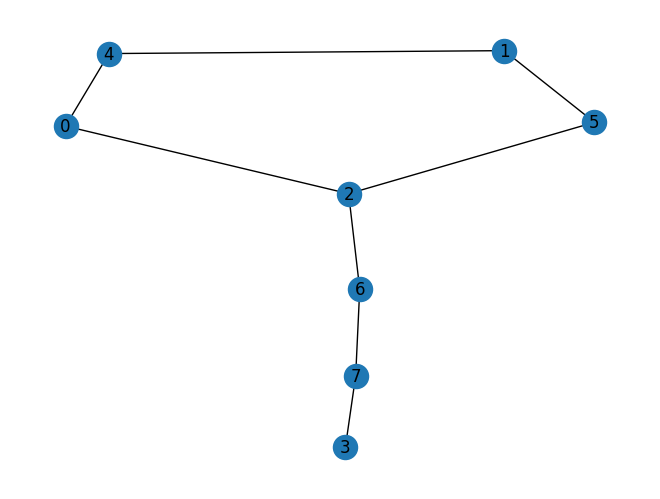

In [46]:
sun_edge_index = torch.tensor([[0, 0, 1, 1, 2, 2, 2, 3, 4, 4, 5, 5, 6, 6, 7, 7],
        [2, 4, 4, 5, 0, 5, 6, 7, 0, 1, 1, 2, 2, 7, 3, 6]])
print(sun_edge_index)
G = nx.Graph()
G.add_edges_from(sun_edge_index.t().tolist())
nx.draw(G, with_labels = True)
src, dst = [1,3]
mask1 = (sun_edge_index[0] != src) | (sun_edge_index[1] != dst)
print(mask1)
mask2 = (sun_edge_index[0] != dst) | (sun_edge_index[1] != src)
sun_edge_index = sun_edge_index[:, mask1 & mask2]
print(sun_edge_index)


In [ ]:
adj = to_scipy_sparse_matrix(sun_edge_index, num_nodes=8).tocsr()
idx = list(range(src)) + list(range(src + 1, adj.shape[0]))
adj_wo_src = adj[idx, :][:, idx]
idx = list(range(dst)) + list(range(dst + 1, adj.shape[0]))
adj_wo_dst = adj[idx, :][:, idx]
print(src,dst)


1 3


In [74]:
from torch_geometric.utils import from_scipy_sparse_matrix

edge_index_wo_src, edge_attr = from_scipy_sparse_matrix(adj_wo_src)

In [95]:
dist2dst = shortest_path(adj_wo_src, directed=False, unweighted=True, indices=dst - 1)
print(dist2dst)
dist2dst = np.insert(dist2dst, src, 0, axis=0)
dist2dst = torch.from_numpy(dist2dst)
dist2src = shortest_path(adj_wo_dst, directed=False, unweighted=True, indices=src)
dist2src = np.insert(dist2src, dst, 0, axis=0)
dist2src = torch.from_numpy(dist2src)
print(dist2dst, dist2src)

[4. 3. 0. 5. 4. 2. 1.]
tensor([4., 0., 3., 0., 5., 4., 2., 1.], dtype=torch.float64) tensor([2., 0., 2., 0., 1., 1., 3., 4.], dtype=torch.float64)


In [101]:
dist = dist2src + dist2dst
print(dist)
dist_over_2, dist_mod_2 = dist // 2, dist % 2
print(dist_over_2, dist_mod_2)

z = 1 + torch.min(dist2src, dist2dst)
print(z)
z += dist_over_2 * (dist_over_2 + dist_mod_2 - 1)
print(z)
z[src] = 1.
z[dst] = 1.
z[torch.isnan(z)] = 0.

tensor([6., 0., 5., 0., 6., 5., 5., 5.], dtype=torch.float64)
tensor([3., 0., 2., 0., 3., 2., 2., 2.], dtype=torch.float64) tensor([0., 0., 1., 0., 0., 1., 1., 1.], dtype=torch.float64)
tensor([3., 1., 3., 1., 2., 2., 3., 2.], dtype=torch.float64)
tensor([9., 1., 7., 1., 8., 6., 7., 6.], dtype=torch.float64)


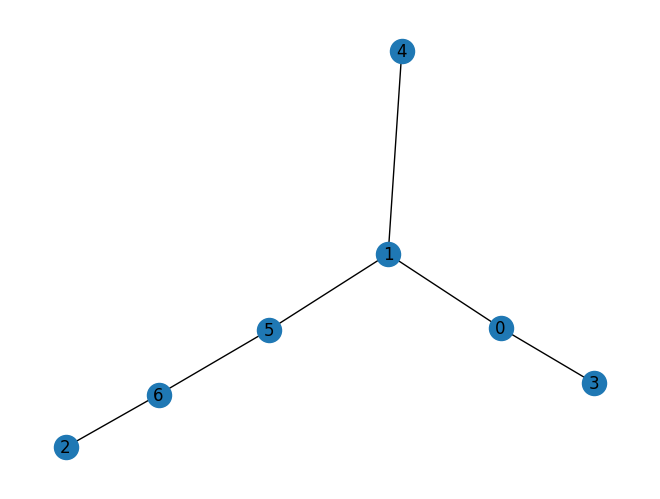

In [75]:
G_wo_src = nx.Graph()
G_wo_src.add_edges_from(edge_index_wo_src.t().tolist())
nx.draw(G_wo_src, with_labels = True)

In [41]:

def drnl_node_labeling(self, edge_index, src, dst, num_nodes=None):
    # Double-radius node labeling (DRNL).
    src, dst = (dst, src) if src > dst else (src, dst)
    adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes).tocsr()

    idx = list(range(src)) + list(range(src + 1, adj.shape[0]))
    adj_wo_src = adj[idx, :][:, idx]

    idx = list(range(dst)) + list(range(dst + 1, adj.shape[0]))
    adj_wo_dst = adj[idx, :][:, idx]

    dist2src = shortest_path(adj_wo_dst, directed=False, unweighted=True,
                                indices=src)
    dist2src = np.insert(dist2src, dst, 0, axis=0)
    dist2src = torch.from_numpy(dist2src)

    dist2dst = shortest_path(adj_wo_src, directed=False, unweighted=True,
                                indices=dst - 1)
    dist2dst = np.insert(dist2dst, src, 0, axis=0)
    dist2dst = torch.from_numpy(dist2dst)

    dist = dist2src + dist2dst
    dist_over_2, dist_mod_2 = dist // 2, dist % 2

    z = 1 + torch.min(dist2src, dist2dst)
    z += dist_over_2 * (dist_over_2 + dist_mod_2 - 1)
    z[src] = 1.
    z[dst] = 1.
    z[torch.isnan(z)] = 0.

    _max_z = max(int(z.max()), self._max_z)

    return z.to(torch.long)

In [ ]:
def extract_enclosing_subgraphs(self, edge_index, edge_label_index, y):
    data_list = []
    for src, dst in edge_label_index.t().tolist():
        sub_nodes, sub_edge_index, mapping, _ = k_hop_subgraph(
            [src, dst], self.num_hops, edge_index, relabel_nodes=True)
        src, dst = mapping.tolist()

        # Remove target link from the subgraph.
        mask1 = (sub_edge_index[0] != src) | (sub_edge_index[1] != dst)
        mask2 = (sub_edge_index[0] != dst) | (sub_edge_index[1] != src)
        sub_edge_index = sub_edge_index[:, mask1 & mask2]

        # Calculate node labeling.
        z = drnl_node_labeling(sub_edge_index, src, dst,
                                    num_nodes=sub_nodes.size(0))

        data = Data(x=data.x[sub_nodes], z=z,
                    edge_index=sub_edge_index, y=y)
        data_list.append(data)

    return data_list

In [ ]:
data_list = extract_enclosing_subgraphs(self, edge_index, edge_label_index, y)

In [1]:
import argparse
import time
import torch
from torch.utils.data import DataLoader
from torch_sparse import SparseTensor
from model import AutoLink_l3, SearchGraph_l31
import os.path as osp
from torch.autograd import Variable
from torch_geometric.datasets import Planetoid
from logger import Logger
from utils import do_edge_split, evaluate_auc, IndexLoader
from torch_geometric.utils import to_undirected, add_self_loops, negative_sampling
import numpy as np

dataset = Planetoid('./dataset/Cora/Cora/', 'cora')

Processing...
Done!


In [3]:
split_edge = do_edge_split(dataset)
print(split_edge)

c:\Users\86186\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


{'train': {'edge': tensor([[   0,  633],
        [   0, 1862],
        [   1,    2],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]]), 'edge_neg': tensor([[1059,  959],
        [ 820, 1230],
        [2682,  965],
        ...,
        [2600, 1508],
        [1568, 2354],
        [ 443,  283]])}, 'valid': {'edge': tensor([[1026, 2034],
        [ 735, 1543],
        [ 741, 1282],
        [ 620, 2534],
        [ 644,  711],
        [  46, 1604],
        [ 283, 2250],
        [ 184,  520],
        [1230, 1342],
        [ 733,  759],
        [ 761, 1443],
        [ 409, 2084],
        [1139, 2054],
        [ 402,  776],
        [ 957, 1557],
        [1623, 1768],
        [ 239, 1759],
        [  95,  861],
        [  61, 2162],
        [1263, 1407],
        [1804, 2451],
        [ 849, 1993],
        [ 148, 2518],
        [ 342, 1072],
        [2476, 2651],
        [2228, 2394],
        [1309, 1625],
        [ 196,  429],
        [  24, 1636],
        [ 625, 102

In [8]:
import difflib
lines1 = open('model.py/AutoLink_Seal.py').readlines()
lines2 = open('model.py/AutoLink_l3Seal.py').readlines()
print(''.join(difflib.unified_diff(lines1, lines2)))

FileNotFoundError: [Errno 2] No such file or directory: 'model.py/AutoLink_Seal.py'

In [37]:
import heapq

In [41]:
import torch
N= data.num_nodes
print(N)
i = 2
k = 0
candidates = [j for j in range(N) if j != k and j!=i]
print(candidates)
src1 = torch.tensor([i] * len(candidates), dtype=torch.long)
dst1 = torch.tensor(candidates, dtype=torch.long)
edge_label_index1 = torch.stack([src1, dst1], dim=0)
src2 = torch.tensor([k] * len(candidates), dtype=torch.long)
dst2 = torch.tensor(candidates, dtype=torch.long)
edge_label_index2 = torch.stack([src2, dst2], dim=0)

scores =[4,11,13,41,22,11]
scores_dist = {i: float(score) for i, score in zip(candidates, scores)}
topk_neighbors = heapq.nlargest(2, scores_dist, key=scores_dist.get)
final_nodes = [i, k] + topk_neighbors
final_nodes = list(set(final_nodes))  # 防止重复
final_nodes.sort()  # 方便后面重新映射

# 旧编号到新编号的映射
node_id_map = {old: new for new, old in enumerate(final_nodes)}
print(scores_dist)
print(edge_label_index2)
print(topk_neighbors)
print(final_nodes)
print(node_id_map)

8
[1, 3, 4, 5, 6, 7]
{1: 4.0, 3: 11.0, 4: 13.0, 5: 41.0, 6: 22.0, 7: 11.0}
tensor([[0, 0, 0, 0, 0, 0],
        [1, 3, 4, 5, 6, 7]])
[5, 6]
[0, 2, 5, 6]
{0: 0, 2: 1, 5: 2, 6: 3}


Epoch: 001, Loss: 0.7098 Train_AUC: 0.7875, Train_AP: 0.7693 Val_AUC: 0.6999, Val_AP: 0.7314 Test_AUC: 0.6743, Test_AP: 0.7054
Epoch: 002, Loss: 0.6451 Train_AUC: 0.7912, Train_AP: 0.7734 Val_AUC: 0.7011, Val_AP: 0.7352 Test_AUC: 0.6773, Test_AP: 0.7087
Epoch: 003, Loss: 0.5647 Train_AUC: 0.7945, Train_AP: 0.7763 Val_AUC: 0.7038, Val_AP: 0.7377 Test_AUC: 0.6813, Test_AP: 0.7108
Epoch: 004, Loss: 0.5105 Train_AUC: 0.7896, Train_AP: 0.7718 Val_AUC: 0.6993, Val_AP: 0.7342 Test_AUC: 0.6761, Test_AP: 0.7072
Epoch: 005, Loss: 0.4723 Train_AUC: 0.7879, Train_AP: 0.7693 Val_AUC: 0.6981, Val_AP: 0.7313 Test_AUC: 0.6752, Test_AP: 0.7051
Epoch: 006, Loss: 0.4483 Train_AUC: 0.7898, Train_AP: 0.7711 Val_AUC: 0.7009, Val_AP: 0.7340 Test_AUC: 0.6784, Test_AP: 0.7085
Epoch: 007, Loss: 0.4310 Train_AUC: 0.7988, Train_AP: 0.7795 Val_AUC: 0.7077, Val_AP: 0.7388 Test_AUC: 0.6874, Test_AP: 0.7155
Epoch: 008, Loss: 0.4182 Train_AUC: 0.8012, Train_AP: 0.7815 Val_AUC: 0.7095, Val_AP: 0.7398 Test_AUC: 0.6890, 

In [9]:
print(data)

Data(x=[8, 5], edge_index=[2, 18])
